In [1]:
from IPython.display import HTML, Image

HTML(
    """
<script
    src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js ">
</script>
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
 } else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit"
    value="Click here to toggle on/off the raw code."></form>
"""
)

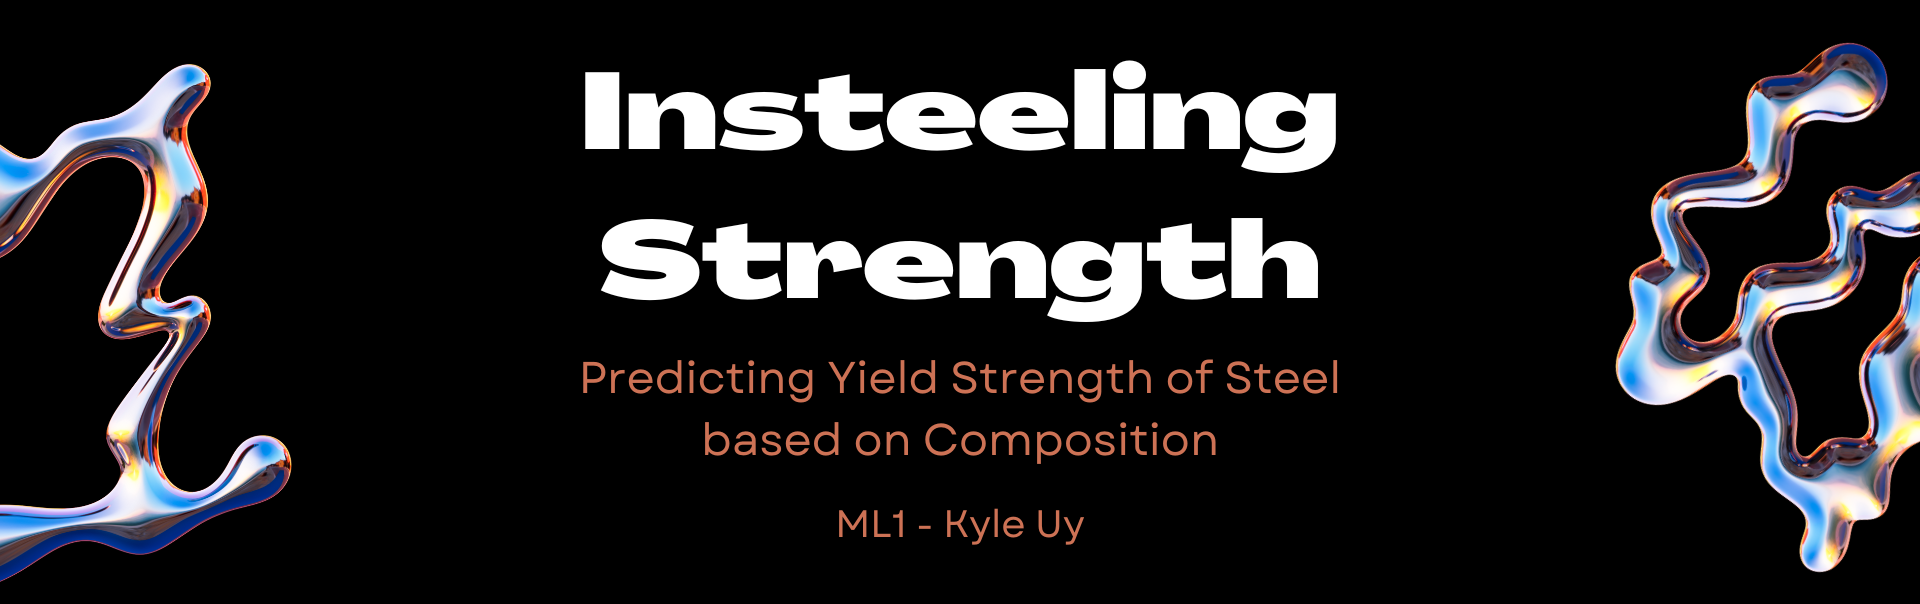

In [2]:
Image(filename='title.png')

<div style="background-color: black; padding: 10px 0;">
<center><h1 style="color: white; font-family:Arial; font-weight:bold">Description of the Problem</h1></center>
</div>

The most accurate way of measuring mechanical properties such as yield strength, ultimate tensile strength, elongation, etc. for steel uses a Universal Testing Machine (UTM). This method takes the sample material and subjects it to continuous tension or compression until it reaches the fracture point. Mechanical testing is considered as a destructive method to determine mechanical properties of steel.

However, certain situations require preservation of the integrity of the sample. Available non-destructive methods give an estimate to the mechanical properties based on different information about the sample material. Depending on the method to be used, the information needed may be of the following:
1. Steel Chemical Composition
2. Processing Conditions (Temperature, Quenching Medium, etc.)
3. Microstructure Characteristics and others

Another method to estimate mechanical properties is to refer to Material Data Sheets that are used by the steel industry. Material Data Sheets give an estimate range of values for each property, which can be a good starting point for some use cases but may also be not enough for others that are looking for an exact measurement. Data Sheets also require for the steel-code type of the sample to be identified so that the correct data sheet can be used. This information, however, should be identified by the time the steel was processed since processing conditions is a major factor in this classification.

This study aims to train a machine learning model that can predict yield strength based on the chemical composition of steel to minimize as much information as possible. The predicted yield strength from the trained model will be compared to the actual yield strength which were measured using a UTM, and as well as to estimated yield strengths that are based on Industry Data Sheets or based on equations established by previous research studies in the Academe.

<div style="background-color: black; padding: 10px 0;">
<center><h1 style="color: white; font-family:Arial; font-weight:bold">Highlights</h1></center>
</div>

- Tree-based methods beat Linear-based and Error-based methods based on $R^2$ in validation
- GradientBoostingRegressor provided the best $R^2$ in testing, beating baseline by twice the score
- GradientBoostingRegressor ran longer than linear-based models, but faster than RandomForestRegressor
- The model predicted Yield Strength with lesser error vs. Estimates from the Industry and Academe
- The model also used less features to predict vs required information to gather established estimates

<div style="background-color: black; padding: 10px 0;">
<center><h1 style="color: white; font-family:Arial; font-weight:bold">Data Source and Description</h1></center>
</div>

The Steel Dataset was sourced from Hacking Materials on Kaggle. Dataset contains 312 steel samples with formula name, chemical composition (% by weight) for 13 chemical elements, and mechanical properties such as yield strength (MPa), tensile strength, and elongation. 

For this study, chemical composition elements were used as features and yield strength was used as target variable. Sample of the dataset is shown below in Table 1.

In [3]:
import warnings

warnings.filterwarnings("ignore")
import time

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor

In [4]:
df = pd.read_csv("steel_strength.csv")
df = df.drop(columns=["formula", "tensile strength", "elongation"])
print("Table 1. Steel Dataset Sample")
df.head()

Table 1. Steel Dataset Sample


,c,mn,si,cr,ni,mo,v,n,nb,co,w,al,ti,yield strength
0,0.02,0.05,0.05,0.01,19.70,2.95,0.01,0.00,0.01,15.00,0.00,0.15,1.55,2411.5
1,0.18,0.01,0.01,13.44,0.01,3.01,0.46,0.04,0.01,19.46,2.35,0.04,0.00,1123.1
2,0.00,0.01,0.01,8.67,13.45,0.82,0.01,0.00,0.01,13.90,0.00,0.39,0.57,1736.3
3,0.01,0.05,0.05,0.01,17.70,3.95,0.01,0.00,0.01,15.00,0.00,0.13,1.47,2487.3
4,0.01,0.05,0.05,0.01,19.40,1.45,0.01,0.00,0.01,14.90,0.00,0.13,1.55,2249.6


Features of the dataset include the chemical elements that are part of steel composition. One thing to note is that not all elements that may be a part of a steel's composition is not included in the dataset. Table 2 shows the included elements, as well as short description of how they are related to steel:

<center>Table 2. Dataset Features Description</center>

| feature name | chemical name | Description |
| ------------ | ------------- | ----------- |
| c | Carbon | most important constituent of steel, raises mechanical properties |
| mn | Manganese | increases mechanical properties |
| si | Silicon | increases tensile and yield strength |
| cr | Chromium | for stainless steel, also increases mechanical properties|
| ni | Nickel | increases mechanical properties |
| mo | Molybdenum | increases mechanical properties |
| v | Vanadium | increases mechanical properties |
| n | Nitrogen | improves stability of alloy structure |
| nb | Niobium |increases mechanical properties |
| co | Cobalt | increases strength and hardness |
| w | Tungsten | increases mechanical properties |
| al | Aluminum | improve impact toughness and corrosion resistance |
| ti | Titanium | stabilizing element in stainless steels |

## Exploratory Data Analysis

To understand the dataset further, Exploratory Data Analysis (EDA) was done. EDA is essential to identify patterns and trends in the dataset, which may provide connections between features.

Additionally, EDA is beneficial in spotting inconsistencies in the data, identifying potential outliers, which might affect the performance of the machine learning model being trained.

In [5]:
print("Table 3. Descriptive Statistics of the Dataset")
df.describe().T

Table 3. Descriptive Statistics of the Dataset


,count,mean,std,min,25%,50%,75%,max
c,312.0,0.096442,0.109008,0.00,0.010,0.030,0.1825,0.43
mn,312.0,0.146250,0.397102,0.01,0.010,0.010,0.0800,3.00
si,312.0,0.221218,0.580796,0.01,0.010,0.010,0.1100,4.75
cr,312.0,8.043830,5.426169,0.01,3.100,9.050,12.5200,17.50
ni,312.0,8.184006,6.337055,0.01,0.960,8.500,12.1175,21.00
mo,312.0,2.766090,1.832908,0.02,1.500,2.210,4.0900,9.67
v,312.0,0.183750,0.452462,0.00,0.010,0.010,0.1275,4.32
n,312.0,0.005545,0.018331,0.00,0.000,0.000,0.0000,0.15
nb,312.0,0.035449,0.161537,0.00,0.010,0.010,0.0100,2.50
co,312.0,7.008782,6.254431,0.01,0.010,7.085,13.4800,20.10


The different ranges of the features shown in Table 3 may indicate that normalization should be done to properly relate each feature to another. However, chemical compositions, the features of this dataset, are in units of %wt. This already makes them comparable with one another.

Figure 1. Histogram of the Dataset


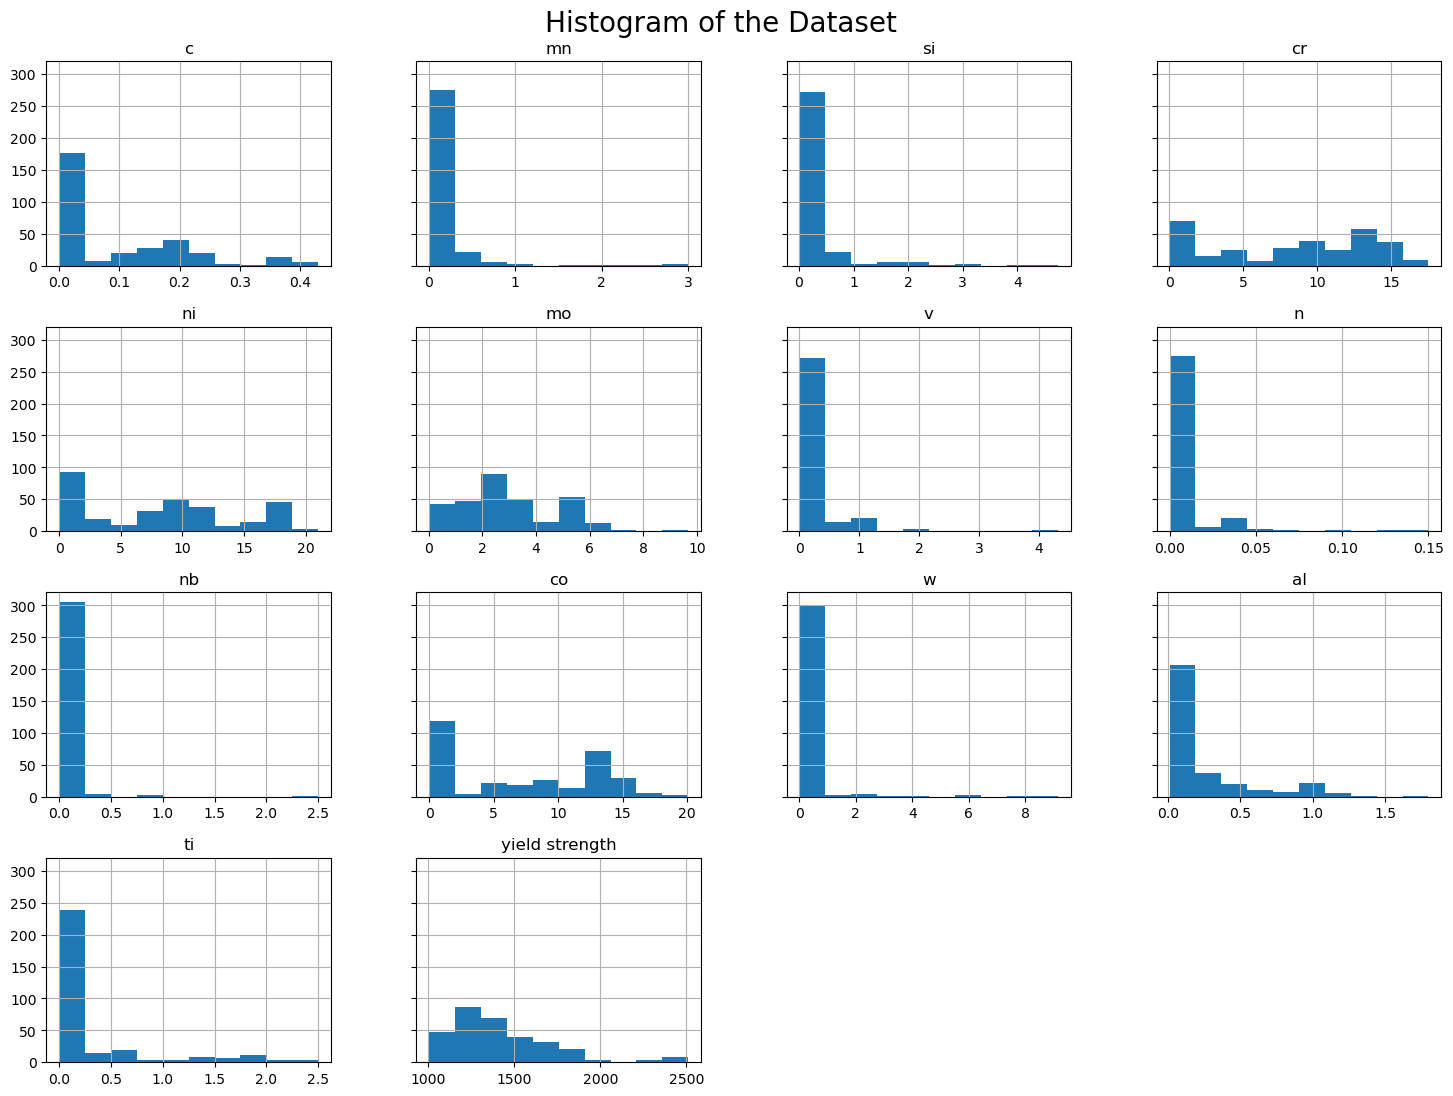

In [6]:
print("Figure 1. Histogram of the Dataset")
ax = df.hist(figsize=(18, 13), sharey=True)
plt.suptitle("Histogram of the Dataset", size=20, y=0.92)
plt.show()

Figure 1 shows the histogram of the dataset. Most of the data are in the lower half of the range for both features and the target variable.

Figure 2. Pairplot of the Features


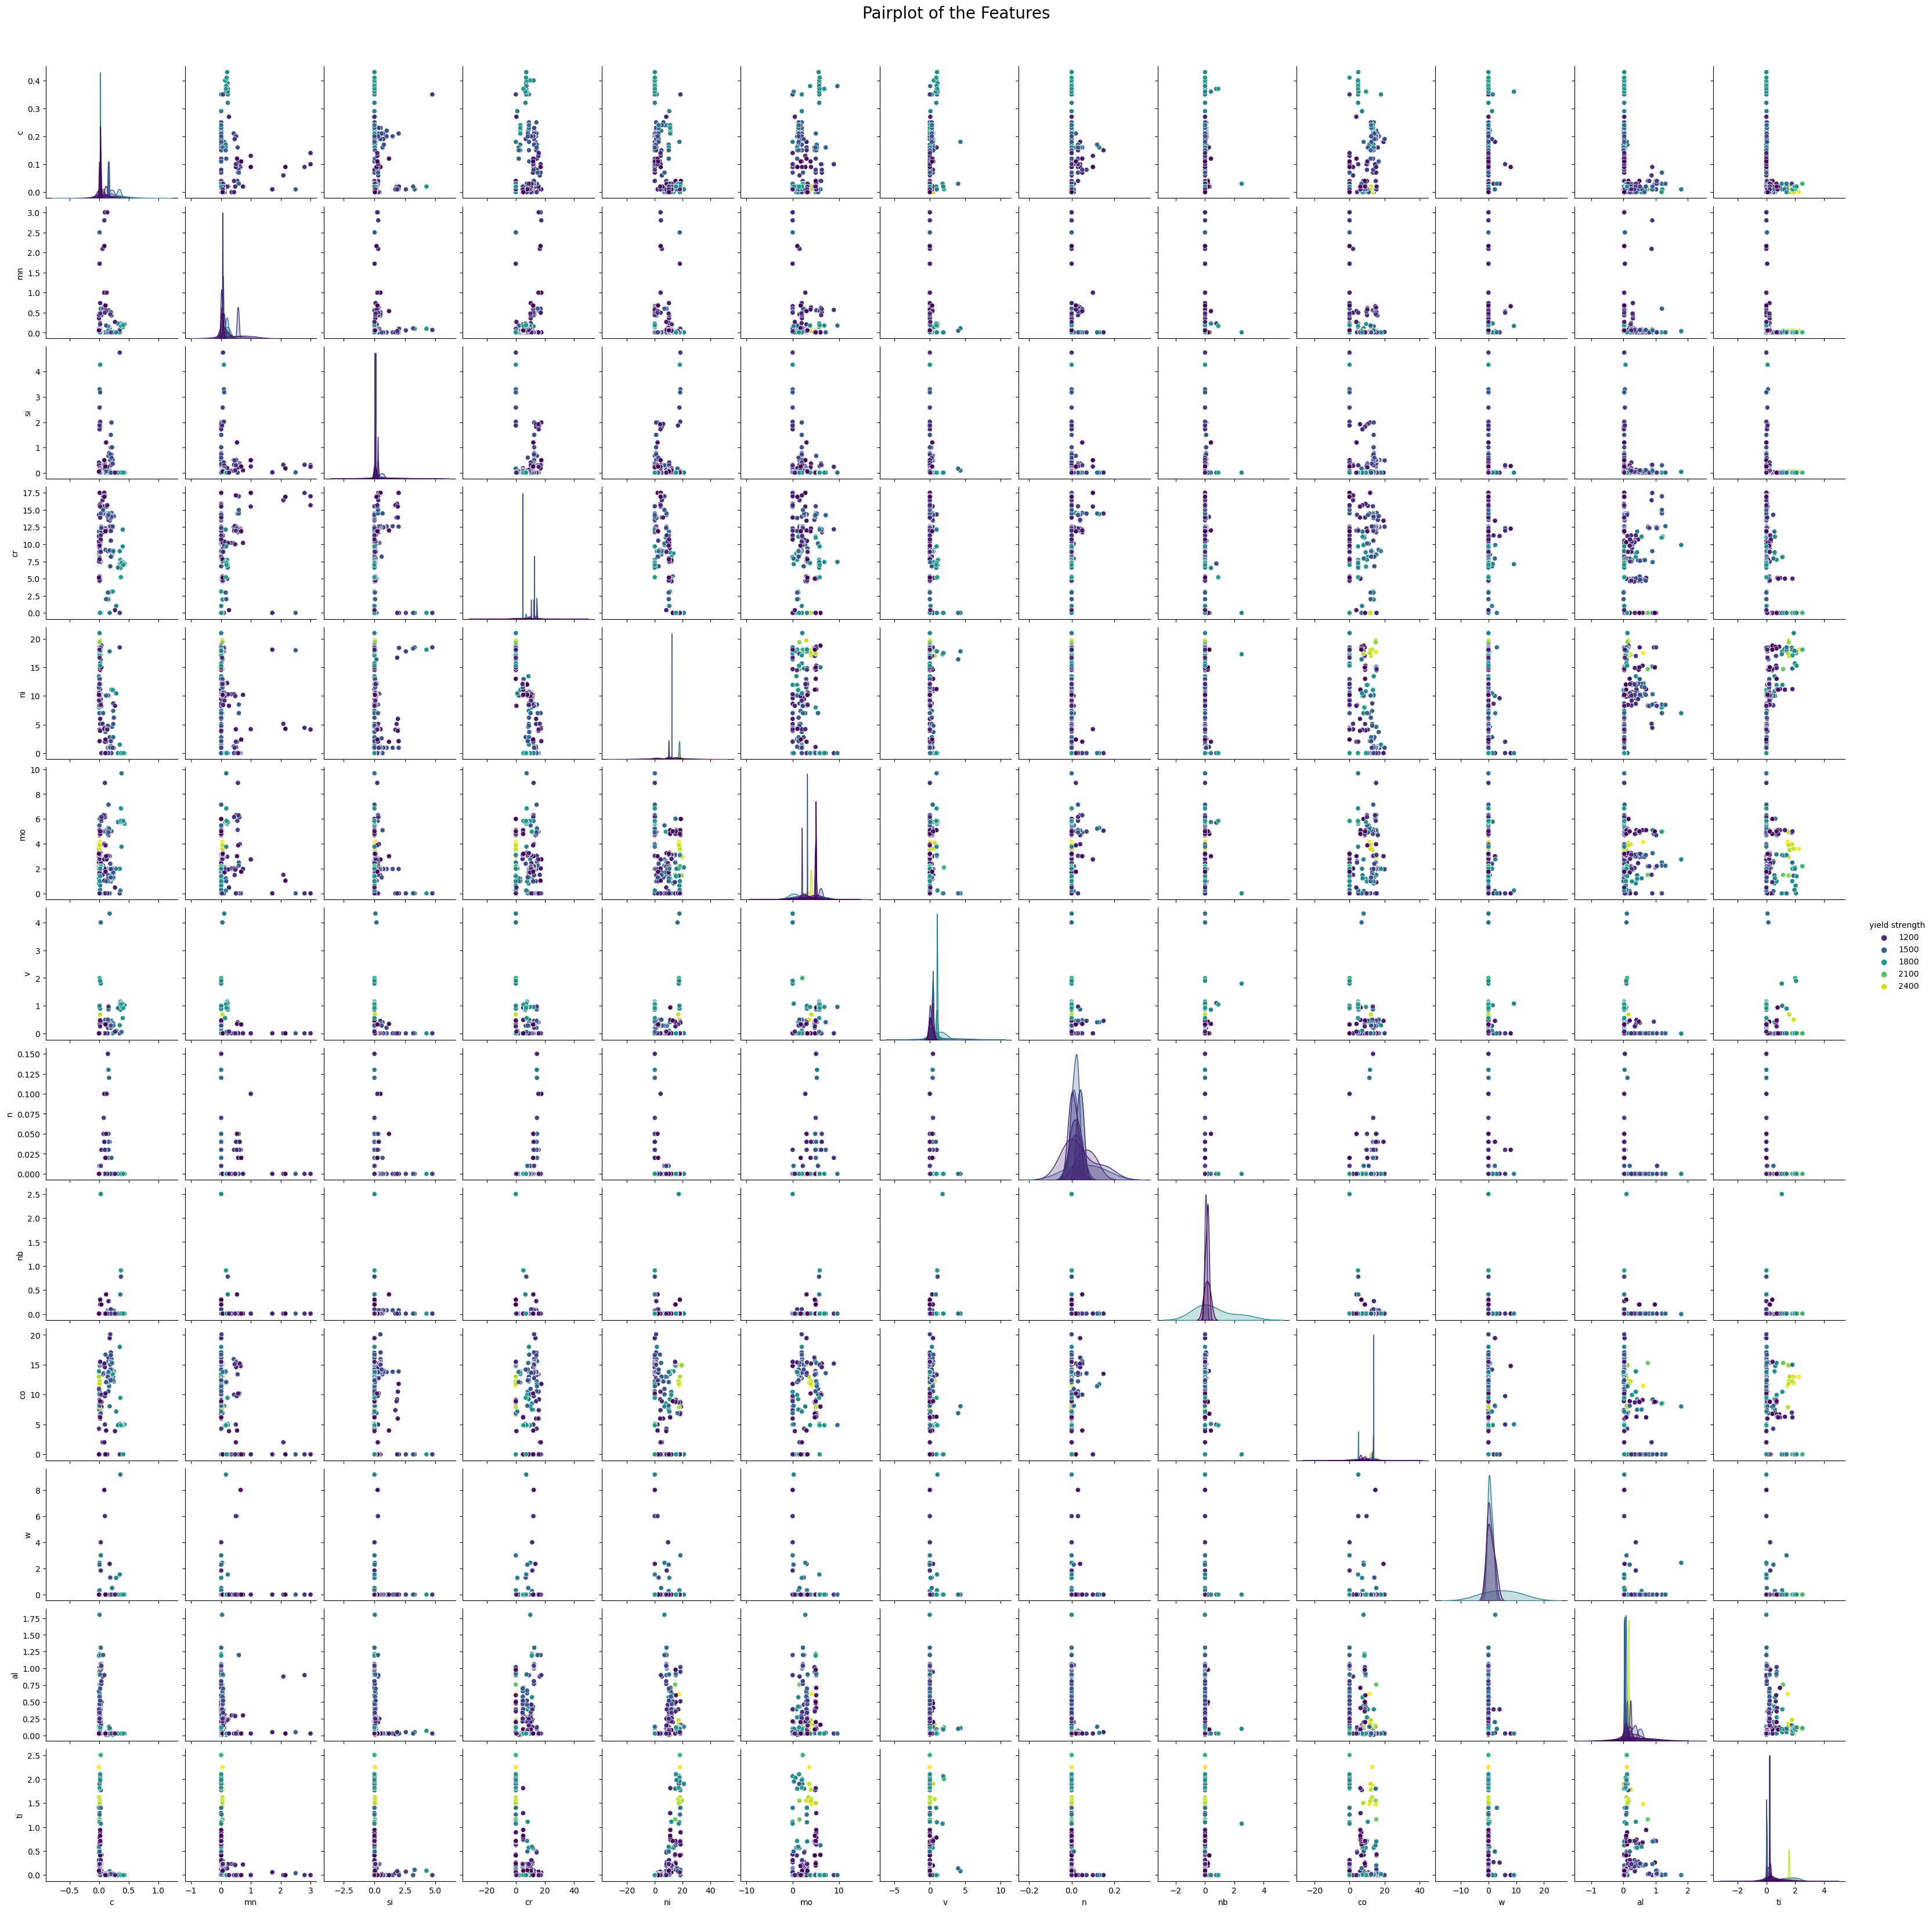

In [7]:
print("Figure 2. Pairplot of the Features")
pairplot = sns.pairplot(df, hue="yield strength", palette="viridis")
plt.suptitle("Pairplot of the Features", size=20, y=1.02)
plt.show()

Figure 2 shows the pairplot of the dataset. This highlights the nature of yield strength in relation to the chemical composition of steel. As seen on the pairplot, increase in Titanium directly affects the yield strength of the steel samples. However, this is not true for other chemicals such as Molybdenum which shows a spread of yield strength throughout its range.

Figure 3. Correlation Matrix of the Features


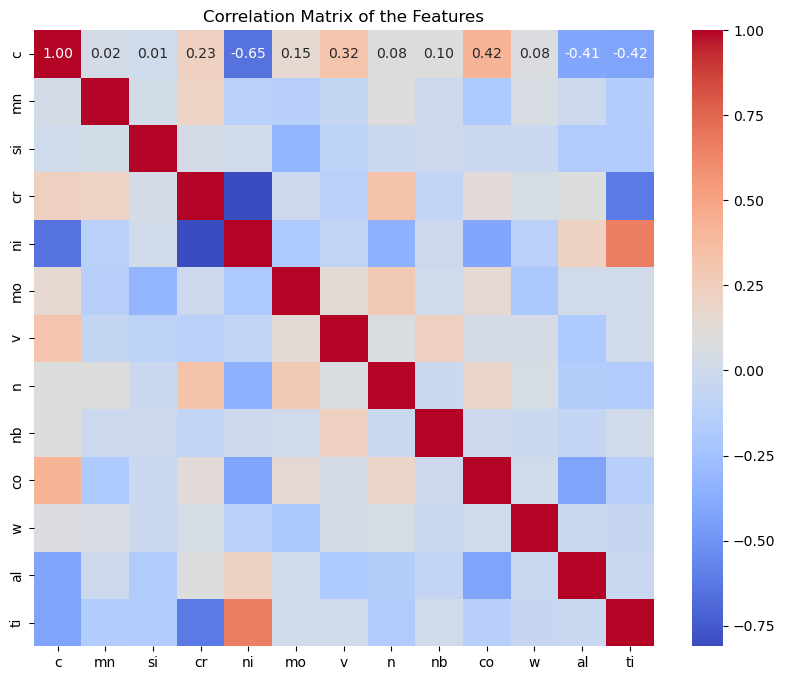

In [8]:
print("Figure 3. Correlation Matrix of the Features")
corr = df.iloc[:, :-1].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of the Features")
plt.show()

Figure 3 shows the correlation matrix for the different features. Correlation of most features are close to 0 which indicates a weak linear relationship. However, Nickel and Titanium has a correlation factor of 0.66 which can be attributed to the use and interaction of Nickel and Titanium in Maraging Steels (Shekhter, 2004).



<div style="background-color: black; padding: 10px 0;">
<center><h1 style="color: white; font-family:Arial; font-weight:bold">Methodology</h1></center>
</div>

The steps of this study is summarized in Figure 4 below:


Figure 4. Methodology Flowchart


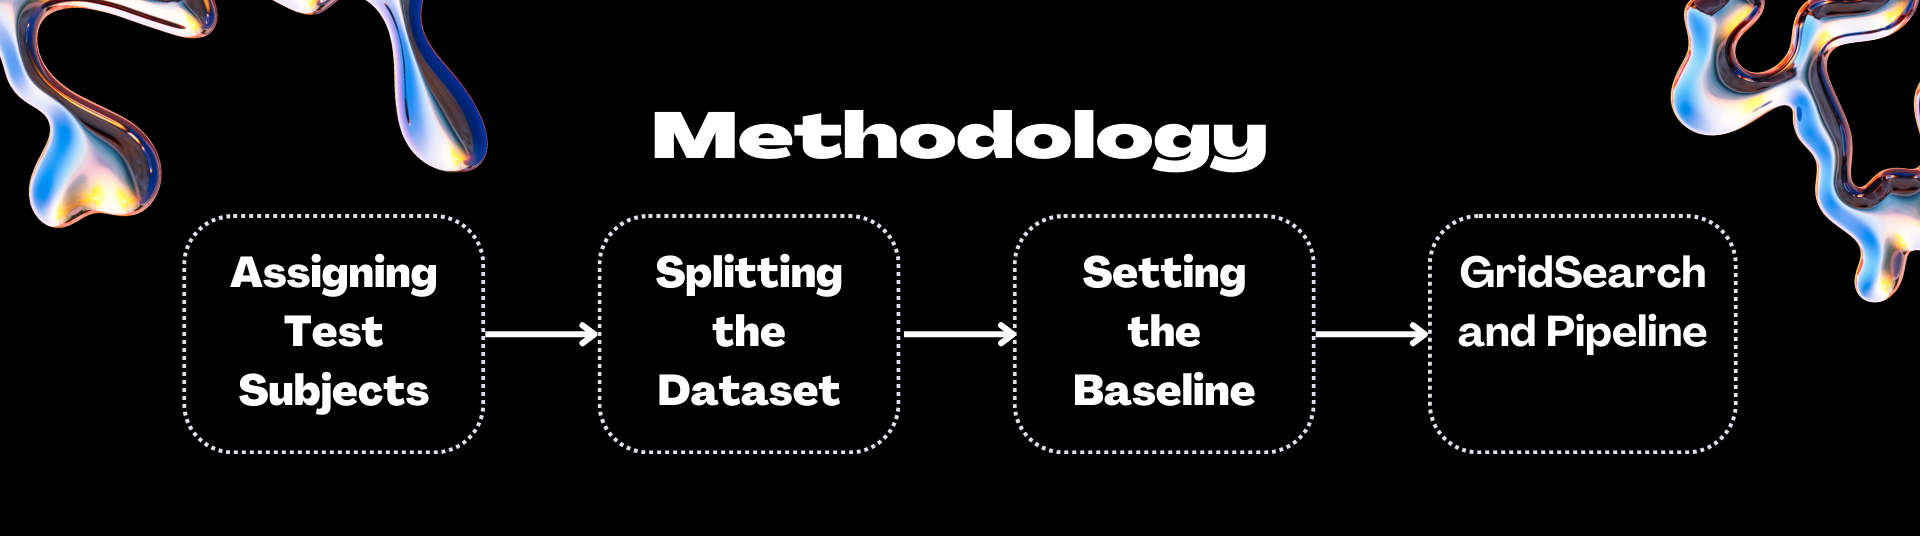

In [9]:
print('Figure 4. Methodology Flowchart')
Image(filename='metho.png')

## Assigning of Test Subjects

To properly compare the predicted yield strength of the model with the estimates used by the industry, test subjects must be excluded from the training data. This ensures that the model is not influenced by these test subjects.

In [10]:
X = df.drop(columns=["yield strength"])
y = df["yield strength"]

### For Data Sheet Comparison

Since steel code/type of each sample is unavailable, finding a test subject for comparison with estimated yield strength from data sheet required manual classification of the steel samples. Assumptions were made due to the lack of information available but ensured that bias introduced by the assumptions was kept to a minimum.

Steel sample with index 49 was classified as **EOS MaragingSteel MS1 DMSL on EOS M290 400W** based on the data sheet provided in MatWeb.com. Classification was based on the chemical composition range provided in the datasheet, as well as the proximity of the estimated yield strength range to the actual yield strength of the sample.

Table 4 shows the actual and estimated yield strength from data sheets of this test subject. 

In [11]:
X_test_subject_ds = X.loc[49]
y_test_subject_ds = pd.Series(y[49], index=[49])
X = X.drop(index=49)
y = y.drop(49)
print("Table 4. Actual and Estimated Yield Strength for Steel Sample 49")
pd.DataFrame(
    [[y_test_subject_ds[49], "1000-1200"]],
    columns=["Actual Yield Strength", "Estimated Yield Strength"],
    index=[49],
)

Table 4. Actual and Estimated Yield Strength for Steel Sample 49


,Actual Yield Strength,Estimated Yield Strength
49,1288.4,1000-1200


The data sheet provides a range for yield strength as an estimate. In this study, we will use the higher limit of the range (1200 MPa) in the computation of percent error due to its closer proximity to the actual value.

### For equation comparison

C-Mn-Ti steels contain up to 0.30% Carbon, with upto 0.40% Manganese, and less than 1% Ti (Singh, 2020). Table 5 shows the list of samples that are classified as C-Mn-Ti steels.

In [12]:
test_subjects = X[
    (X["ti"] > 0)
    & (X["ti"] < 0.1)
    & (X["c"] > 0)
    & (X["c"] <= 0.3)
    & (X["mn"] <= 0.4)
    & (X["co"] < 0.1)
    & (X["ni"] < 10)
]
test_index = set(test_subjects.index)
print("Table 5. C-Mn-Ti Steels in the dataset")
test_subjects

Table 5. C-Mn-Ti Steels in the dataset


,c,mn,si,cr,ni,mo,v,n,nb,co,w,al,ti
177,0.03,0.01,0.01,12.64,8.44,2.24,0.01,0.00,0.01,0.01,0.0,1.31,0.01
180,0.03,0.01,0.01,12.51,8.36,2.22,0.01,0.00,0.01,0.01,0.0,1.06,0.09
182,0.03,0.01,0.01,12.49,8.31,2.21,0.01,0.01,0.01,0.01,0.0,1.06,0.09
183,0.03,0.01,0.01,12.49,8.31,2.22,0.01,0.00,0.01,0.01,0.0,1.07,0.05
184,0.03,0.01,0.01,12.52,8.34,2.21,0.01,0.01,0.01,0.01,0.0,1.06,0.02
185,0.03,0.01,0.01,12.57,8.29,2.22,0.01,0.01,0.01,0.01,0.0,1.05,0.01
186,0.03,0.01,0.01,12.54,8.38,2.24,0.01,0.00,0.01,0.01,0.0,1.03,0.01
187,0.04,0.01,0.01,12.49,8.30,2.23,0.01,0.00,0.01,0.01,0.0,1.07,0.01
188,0.04,0.01,0.01,12.51,8.32,2.22,0.01,0.00,0.01,0.01,0.0,1.06,0.05
191,0.03,0.01,0.01,12.51,8.28,2.20,0.01,0.01,0.01,0.01,0.0,1.05,0.05


The equation used in estimating yield strength for C-Mn-Ti steels (Eqn 1) was derived by Ren, J. and Liu, Z. in their research paper referenced below (2019).

$$
\text{Yield Strength (MPa)} = 37[\text{Mn}] + 83[\text{Si}] + 59[\text{Al}] + 38[\text{Cu}] + 11[\text{Mo}] + 33[\text{Ni}] - 30[\text{Cr}] + 680[\text{P}] + \sigma_p + 17.4d^{-0.5}_\alpha + 98.7
$$
<center>$d_\alpha$ - ferrite grain size, mm; $\sigma_p$ - precipitation strengthening</center>
<br>
<center>Equation 1. Yield Strength Prediction of C-Mn-Ti Steel</center>
<br>

Composition values for Cu and P were assumed as zero since it was not found in the dataset features. Furthermore, due to lack of processing condition and microstructure information available, $d_\alpha$ - ferrite grain size & $\sigma_p$ - precipitation strengthening, were estimated using statistical methods. The summation of these two variables will be taken as a constant, called as 'additional_ys'.

To estimate additional_ys for all samples in the C-Mn-Ti steel set, a function 'partial_ys' was created to compute for the partial yield strength described by the chemical composition terms available in the dataset.

In [13]:
def partial_ys(*e):
    return (37 * e[0]
            + 83 * e[1]
            + 59 * e[2]
            + 11 * e[3]
            + 33 * e[4]
            - 30 * e[5]
            + 98.7)

Partial yield strengths were computed for each steel sample in the C-Mn-Ti steel set. Afterwards, additional_ys for each sample was computed by subtracting the partial yield strength from their actual yied strength in the dataset. The average value of all additional_ys will be used as the constant for estimation.

In [14]:
partial_ys_list = []
for i in range(len(test_subjects)):
    ts = test_subjects.iloc[i]
    partial_ys_list.append(partial_ys(ts[1],
                                      ts[2],
                                      ts[-2],
                                      ts[5],
                                      ts[4],
                                      ts[3]))
test_ys = df.loc[test_subjects.index, "yield strength"]
additional_ys_list = test_ys - partial_ys_list
additional_ys_constant = additional_ys_list.mean()

Two steel samples will be used as test subjects for the comparison between predicted and estimated from equation method. Steel samples with indices 182 and 192 were determined to be the test subjects as they are part of the C-Mn-Ti steel set. Both of these test subjects will be included in the holdout set, and their estimated yield strength are computed. Table 6 shows the actual and estimate yield strength of the two test subjects.

In [15]:
eqn_test_index = [182, 192]
partial_ys_test = []
for i in eqn_test_index:
    ts = test_subjects.loc[i]
    partial_ys_test.append(partial_ys(ts[1],
                                      ts[2],
                                      ts[-2],
                                      ts[5],
                                      ts[4],
                                      ts[3]))
est_ys = partial_ys_test + additional_ys_constant
print("Table 6. Actual and Estimated Yield Strength for Steel Samples"
      " 182 & 192")
pd.DataFrame(
    {"Actual Yield Strength": y[eqn_test_index],
     "Estimated Yield Strength": est_ys},
    index=eqn_test_index,
)

Table 6. Actual and Estimated Yield Strength for Steel Samples 182 & 192


,Actual Yield Strength,Estimated Yield Strength
182,1357.9,1320.078947
192,1296.0,1319.588947


In [16]:
X_test_subject_eqn = X.loc[eqn_test_index]
y_test_subject_eqn = pd.Series(y[eqn_test_index], index=[182, 192])
X = X.drop(index=eqn_test_index)
y = y.drop(eqn_test_index)

## Splitting the Dataset

The dataset was separated into two: feature matrix and the target array. X was set as the feature matrix containing the chemical composition (%wt) and y was set as the target array containing the actual yield strength of the steel samples (MPa).

X and y were split using train_test_split function in scikit-learn package into two: training and holdout sets. Afterwards, the test subjects that were excluded previously were then added to the holdout set.

In [17]:
X_trainval, X_holdout, y_trainval, y_holdout = train_test_split(
    X, y, test_size=0.2, random_state=0
)

In [18]:
X_holdout_concat = pd.concat(
    [X_holdout, pd.DataFrame(X_test_subject_ds).T, X_test_subject_eqn]
)
y_holdout_concat = pd.concat([y_holdout, y_test_subject_ds,
                              y_test_subject_eqn])

## Setting Baseline

Baseline for the model was set by using Linear Regression on the dataset. A Linear Regression model was fitted on the training set and was used to predict yield strength of the holdout set. The $R^2$ score of the Predicted vs Actual Yield Strength of the holdout set shown on Figure 5 was calculated to be 0.4019.

In [19]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X_trainval, y_trainval)
r2_lr = r2_score(y_holdout_concat, lr.predict(X_holdout_concat))

Figure 5. Predicted vs Actual Yield Strength for Linear Regression
R2 = 0.4019


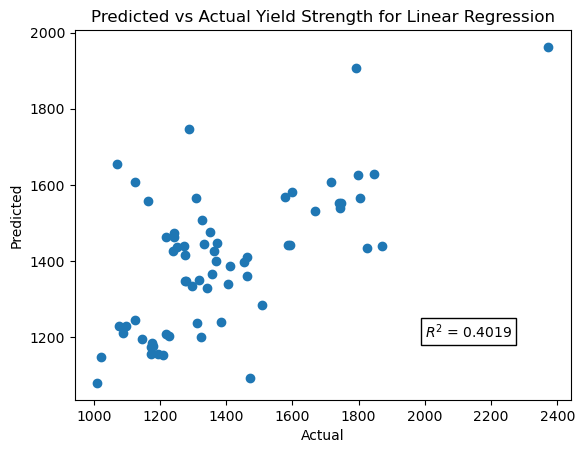

In [20]:
print("Figure 5. Predicted vs Actual Yield Strength for Linear Regression")
print(f"R2 = {r2_lr:.4f}")
plt.plot(y_holdout_concat, lr.predict(X_holdout_concat), "o")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual Yield Strength for Linear Regression")
plt.text(
    2000, 1200, f"$R^2$ = {r2_lr:.4f}", bbox=dict(boxstyle="square",
                                                  fc="w",
                                                  ec="k")
)
plt.show()

## GridSearch and Pipeline

Finding a suitable machine learning model with optimal settings can be an arduous process. To streamline this, Pipeline and GridSearchCV functions from scikit-learn were used. Pipeline was used to create the steps for the optimization of the different models and GridSearchCV was used to automate the optimization process. The resulting best estimator model and its hyperparameters will be used as the model for this study.

The models considered are the ff:
- LinearSVR
- Ridge
- Lasso
- KNeighborsRegressor
- DecisionTreeRegressor
- RandomForestRegressor
- GardientBoostingRegressor

Hyperparameters used for each Regressor are listed in table 4 below:

<center>Table 7. Hyperparameter settings per Regressor</center>

|Regressor|Hyperparameter and Settings|
| :---: | :---: |
|LinearSVR|C = np.logspace(-4, 0, 5)|
|Ridge|alpha = np.logspace(-1, 5, 5)|
|Lasso|alpha = np.logspace(-1, 5, 5)|
|KNeighborsRegressor|n_neighbor = range(5, 16, 3)|
|DecisionTreeRegressor|max_feature = np.linspace(0.4, 0.7, 7) <br> max_depth = range(45, 51, 1)|
|RandomForestRegressor|n_estimators = range(500, 701, 50) <br> max_feature = np.linspace(0.4, 0.7, 7) <br> max_depth = range(45, 51, 1)|
|GardientBoostingRegressor|n_estimators = range(500, 701, 50) <br> max_feature = np.linspace(0.4, 0.7, 7) <br> max_depth = range(45, 51, 1) <br> learning_rate = [0.13, 0.14, 0.15]|

In [21]:
C_range = np.logspace(-4, 0, 5)
alpha_range = np.logspace(-1, 5, 5)
max_depth_range = range(45, 51, 1)
n_estimators = range(500, 701, 50)
learning_rate_range = [0.13, 0.14, 0.15]
n_neighbor_range = range(5, 16, 3)
max_feature_range = np.linspace(0.4, 0.7, 7)

In [22]:
steps = [("reg", None)]
pipe = Pipeline(steps)
param_grid = [
    {"reg": [LinearSVR(dual="auto")], "reg__C": C_range},
    {"reg": [Ridge(), Lasso(max_iter=10000)], "reg__alpha": alpha_range},
    {"reg": [KNeighborsRegressor()], "reg__n_neighbors": n_neighbor_range},
    {
        "reg": [DecisionTreeRegressor()],
        "reg__max_depth": max_depth_range,
        "reg__max_features": max_feature_range,
    },
    {
        "reg": [RandomForestRegressor()],
        "reg__max_depth": max_depth_range,
        "reg__n_estimators": n_estimators,
        "reg__max_features": max_feature_range,
    },
    {
        "reg": [GradientBoostingRegressor()],
        "reg__max_depth": max_depth_range,
        "reg__learning_rate": learning_rate_range,
        "reg__n_estimators": n_estimators,
        "reg__max_features": max_feature_range,
    },
]

<div style="background-color: black; padding: 10px 0;">
<center><h1 style="color: white; font-family:Arial; font-weight:bold">Results and Discussion</h1></center>
</div>

## GridSearchCV Results

GridSearchCV was run in the following section and its results will be discussed below.

In [23]:
cv = 5
scoring = "r2"
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    verbose=0,
    return_train_score=True,
)
grid_search.fit(X_trainval, y_trainval)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('reg', None)]), n_jobs=-1,
             param_grid=[{'reg': [LinearSVR(dual='auto')],
                          'reg__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])},
                         {'reg': [Ridge(), Lasso(max_iter=10000)],
                          'reg__alpha': array([1.00000000e-01, 3.16227766e+00, 1.00000000e+02, 3.16227766e+03,
       1.00000000e+05])},
                         {'reg': [KNeighborsRegressor()],
                          'reg__n_neighbo...
                          'reg__max_depth': range(45, 51),
                          'reg__max_features': array([0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ]),
                          'reg__n_estimators': range(500, 701, 50)},
                         {'reg': [GradientBoostingRegressor()],
                          'reg__learning_rate': [0.13, 0.14, 0.15],
                          'reg__max_depth': range(45, 51),
                          'reg__max_features': array([0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ]),
                          'reg__n_estimators': range(500, 701, 50)}],
             return_train_score=True, scoring='r2')

In [24]:
cv_results = pd.DataFrame(grid_search.__dict__["cv_results_"])
print("Table 8. Top 5 Models from GridSearchCV")
cv_results.sort_values("mean_test_score", ascending=False).head()

Table 8. Top 5 Models from GridSearchCV


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg,param_reg__C,param_reg__alpha,param_reg__n_neighbors,param_reg__max_depth,param_reg__max_features,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
376,0.611295,0.035523,0.005466,0.001655,GradientBoostingRegressor(),NaN,NaN,NaN,48,0.4,...,0.799636,0.088646,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
779,0.781877,0.083276,0.006284,0.001049,GradientBoostingRegressor(),NaN,NaN,NaN,47,0.55,...,0.798206,0.088233,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0
489,0.723043,0.057206,0.004864,0.000689,GradientBoostingRegressor(),NaN,NaN,NaN,45,0.45,...,0.797902,0.063975,3,1.0,1.0,1.0,1.0,1.0,1.0,0.0
573,0.690038,0.097296,0.005089,0.000603,GradientBoostingRegressor(),NaN,NaN,NaN,47,0.6,...,0.795913,0.087361,4,1.0,1.0,1.0,1.0,1.0,1.0,0.0
412,0.658386,0.037237,0.005332,0.001207,GradientBoostingRegressor(),NaN,NaN,NaN,49,0.4,...,0.795414,0.084941,5,1.0,1.0,1.0,1.0,1.0,1.0,0.0


Table 8 shows the top five models from the results of the GridSearchCV. GradientBoostingRegressor dominated the results, with mean test scores only varying within a short range.

In [25]:
print("Table 9. Best Result for each type of Model")
cv_results.sort_values("mean_test_score", ascending=False).drop_duplicates(
    subset="param_reg"
)

Table 9. Best Result for each type of Model


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg,param_reg__C,param_reg__alpha,param_reg__n_neighbors,param_reg__max_depth,param_reg__max_features,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
376,0.611295,0.035523,0.005466,0.001655,GradientBoostingRegressor(),NaN,NaN,NaN,48,0.4,...,0.799636,0.088646,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
266,1.857131,0.180382,0.058505,0.009826,RandomForestRegressor(),NaN,NaN,NaN,50,0.7,...,0.792716,0.070435,8,0.976147,0.970106,0.975996,0.972774,0.977137,0.974432,0.002614
46,0.005417,0.000120,0.002658,0.000058,DecisionTreeRegressor(),NaN,NaN,NaN,48,0.7,...,0.674387,0.120632,841,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
15,0.003157,0.000754,0.002978,0.000838,KNeighborsRegressor(),NaN,NaN,5,NaN,NaN,...,0.624054,0.137823,843,0.825273,0.763341,0.785319,0.738998,0.810775,0.784741,0.031213
11,0.005158,0.000196,0.002851,0.000092,Lasso(max_iter=10000),NaN,3.162278,NaN,NaN,NaN,...,0.413851,0.068683,883,0.531405,0.508566,0.523741,0.462590,0.529020,0.511064,0.025506
5,0.013410,0.004428,0.003137,0.000221,Ridge(),NaN,0.1,NaN,NaN,NaN,...,0.392248,0.143354,884,0.578545,0.546021,0.553168,0.501117,0.560731,0.547916,0.025782
4,0.004397,0.000167,0.002790,0.000128,LinearSVR(dual='auto'),1.0,NaN,NaN,NaN,NaN,...,-0.545086,0.450733,897,-0.266516,-0.517866,-0.269140,-0.406388,-0.232713,-0.338525,0.107670


In [26]:
grid_search.best_estimator_.get_params()["steps"][0][1]

GradientBoostingRegressor(learning_rate=0.13, max_depth=48, max_features=0.4,
                          n_estimators=500)

Table 9 shows the best result for each type of the models with considered. Tree-based models came on top with RandomForestRegressor having a score close to the top GradientBoostingRegressor. KNeighborRegressor showed comparable results to Tree-based models, while Linear-based models Ridge and Lasso did not improve much from the baseline Linear Regression.

GridSearchCV results show that the best model based on the training data was GradientBoostingRegressor with the following hyperparameters:

<center>Table 10. Hyperparameter and Optimal Settings for GradientBoostingRegressor</center>

| Hyperparameter | Optimal setting |
| -------------- | --------------- |
| n_estimators   | 500 |
| learning rate  | 0.13 |
| max_depth      | 48|
| max_features   | 0.4 |

with an $R^2$ score of 0.8689.

These hyperparameter settings will be used to fit the GradientBoostingRegressor on the training set and create the model for this study. Afterwards, model was used to predict the yield strength of the holdout set.

The graph below, Figure 6, shows the predicted vs actual yield strength of the holdout set.

Figure 6. Predicted vs Actual Yield Strength for Gradient Boosting Regressor
R2 = 0.8689


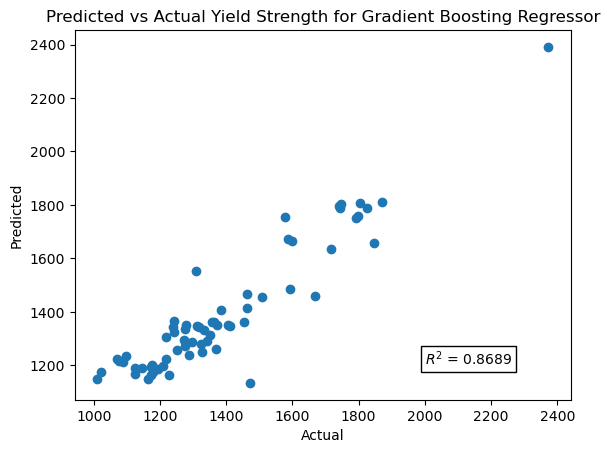

In [27]:
best_model = grid_search.best_estimator_
best_model.fit(X_trainval, y_trainval)
r2_best_model = best_model.score(X_holdout_concat, y_holdout_concat)
print("Figure 6. Predicted vs Actual Yield Strength for"
      " Gradient Boosting Regressor")
print(f"R2 = {r2_best_model:.4f}")
plt.plot(y_holdout_concat, best_model.predict(X_holdout_concat), "o")
plt.title("Predicted vs Actual Yield Strength for Gradient Boosting Regressor")
plt.text(
    2000,
    1200,
    f"$R^2$ = {r2_best_model:.4f}",
    bbox=dict(boxstyle="square", fc="w", ec="k"),
)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

Compared to the Linear Regression baseline, the Gradient Boosting Regressor model showed an improvement of more than double the score of the former. The higher $R^2$ score of the test set vs. training set may be attributed to chance in the splitting of the two sets.

## Comparison of Test Subjects

The true value of this model is its ability to predict yield strength of steel that is more usable than estimates used by the industry or academe which requires a lot more information.

The tables below show the comparison between predicted and estimated yield strength of the test subjects for both data sheet and equation estimation. These values were compared to the actual value of the yield strength that was measured using UTM by getting the % error.

In [28]:
predicted_YS = best_model.predict(X_test_subject_ds.to_numpy().reshape(1, -1))
print(
    "Table 11. Actual, Predicted, and Estimate (Data Sheet) Yield Strength"
    " for Sample Steel 49"
)
pd.DataFrame(
    {
        "Actual": y_test_subject_ds,
        "Predicted": predicted_YS,
        "Predicted Error %": np.abs(
            (y_test_subject_ds - predicted_YS) / y_test_subject_ds
        )
        * 100,
        "Estimate": "1000-1200",
        "Estimate Error %": np.abs((y_test_subject_ds - 1200)
                                   / y_test_subject_ds)
        * 100,
    }
)

Table 11. Actual, Predicted, and Estimate (Data Sheet) Yield Strength for Sample Steel 49


,Actual,Predicted,Predicted Error %,Estimate,Estimate Error %
49,1288.4,1240.030362,3.754241,1000-1200,6.861223


Table 11 shows the comparison of the predicted yield strength and estimated yield strength from data sheet to the actual yield strength of steel sample 49. The percent error of the model's prediction is better than the estimate by around 3%. The prediction was below the target value by almost 50 MPa, whereas the estimate was initially a range of values from 1000-1200 MPa.

In [29]:
predicted_YS_eqn = best_model.predict(X_test_subject_eqn)
print(
    "Table 12. Actual, Predicted, and Estimate (Equation) Yield Strength"
    " for Sample Steels 182 and 192"
)
pd.DataFrame(
    {
        "Actual": y_test_subject_eqn,
        "Predicted": predicted_YS_eqn,
        "Predicted Error %": np.abs(
            (y_test_subject_eqn - predicted_YS_eqn) / y_test_subject_eqn
        )
        * 100,
        "Estimate": est_ys,
        "Estimate Error %": np.abs((y_test_subject_eqn - est_ys)
                                   / y_test_subject_eqn)
        * 100,
    }
)

Table 12. Actual, Predicted, and Estimate (Equation) Yield Strength for Sample Steels 182 and 192


,Actual,Predicted,Predicted Error %,Estimate,Estimate Error %
182,1357.9,1363.119758,0.384399,1320.078947,2.785261
192,1296.0,1286.633193,0.722747,1319.588947,1.820135


Table 12 shows the comparison of the predicted yield strength and estimated yield strength based on equation to the actual yield strength of steel samples 182 and 192. The predicted yield strengths had less than 1% error vs the actual yield strength. The percent error of the model's prediction were marginally better than the estimates from Eqn 1, beating it by about 1.0-2.5%. Moreover, it should be noted that the estimates have inherent bias in their estimation since it was calculated using the actual values of the samples which meant the values were already inclined to be closer to the actual value. 

<div style="background-color: black; padding: 10px 0;">
<center><h1 style="color: white; font-family:Arial; font-weight:bold">Conclusion</h1></center>
</div>

This study found that using an optimized GradientBoostingRegressor Model predicts yield strength better than estimates established by the Steel Industry and Academe. Most notably, the model was trained using only chemical composition of different steel samples as features, which is less information than what is required by industry and academe estimates. The model was predicting around 3% better than the estimates from data sheets and around 1.0-2.5% better than the estimates from the C-Mn-Ti yield strength equation.

The model predictions also had an $R^2$ score of 0.8830 which was more than twice better than the baseline Linear Regression model.

<div style="background-color: black; padding: 10px 0;">
<center><h1 style="color: white; font-family:Arial; font-weight:bold">Recommendation</h1></center>
</div>

The availability of information limited the capacity of this study. To improve on this, more information about the steel samples such as steel code, processing conditions (working temperature, quenching medium, etc.), and others can be used to properly compare the predictions with industry and academe estimates.

Such information can also directly help the model become more flexible. Linear models established by the academic community work only a specific type of steel due since those are reliant on the certain chemical composition or working condition done. The benefit of using Decision Tree-based models is that it can be more flexible to the different types of steel available, and can make predictions on yield strength by adding those information to the model.

Lastly, other mechanical properties of steel may also be predicted by machine learning models. In doing so, it gives users better understanding of the type of steel they are working with.

<div style="background-color: black; padding: 10px 0;">
<center><h1 style="color: white; font-family:Arial; font-weight:bold">References</h1></center>
</div>

*Application of niobium in the steel industry*. (2020, December 18). Refractory Metals and Alloys. https://www.refractorymetal.org/application-of-niobium-in-the-steel-industry/

Corsetti Silva, G., & Pitz, D. B. (2020). Prediction of yield and tensile strengths for high-alloy steels from chemical composition: a data preprocessing approach. *XXVII Congresso Nacional de Estudantes de Engenharia Mecânica*.

*EOS MaragingSteel MS1 DMSL on EOS M290 400W*. Matweb.com. Retrieved December 8, 2023, from https://www.matweb.com/search/DataSheet.aspx?MatGUID=e5f29adb099343f2b9b2c49e6e128bed

Gawlik, J., Schmidt, J., Nowak, T., Wójcicki, Z., & Zagórski, A. (2017). Nitrogen as an alloying element improving material properties of the high carbon cast steel for ball mill liner plates. *Archives of Civil and Mechanical Engineering, 17*(4), 926–934. https://doi.org/10.1016/j.acme.2017.04.007

Hacking Materials. (2022). *Steel Strength Data 2018* [Data set]. Kaggle.

LTD. (2019, October 7). *The effect of aluminum in steel*. XI’AN LINHUI IMPORT & EXPORT CO., LTD. https://www.lksteelpipe.com/news/the-effect-of-aluminum-in-steel-27994294.html

Malhotra, M. G. (2023, July 17). Test the tensile & compression both with UTM. *Prestogroup*. https://www.prestogroup.com/blog/test-the-tensile-compression-both-with-utm/

*Most common alloying elements in steel*. (2020, November 10). Diehl Tool Steel, Inc. https://www.diehlsteel.com/technical-information/effects-of-common-alloying-elements-in-steel/

Ren, J., & Liu, Z. (2019). Mechanical properties and strength prediction of Ti microalloyed low carbon steel with different Ti content. *IOP Conference Series. Materials Science and Engineering, 611*(1), 012010. https://doi.org/10.1088/1757-899x/611/1/012010

Shekhter, A., Aaronson, H. I., Miller, M. R., Ringer, S. P., & Pereloma, E. V. (2004). Effect of aging and deformation on the microstructure and properties of Fe-Ni-Ti maraging steel. *Metallurgical and Materials Transactions A, 35*(3), 973–983. https://doi.org/10.1007/s11661-004-0024-9

Singh, R. (2020). *Applied welding engineering: Processes, codes, and standards* (3rd ed.). Butterworth-Heinemann.

<div style="background-color: black; padding: 10px 0;">
<center><h1 style="color: white; font-family:Arial; font-weight:bold">Acknowledgements</h1></center>
</div>

The author expresses his gratitude to Prof. Chris Monterola and Prof. Leo Lorenzo II for their invaluable assistance and mentorship throughout the Machine Learning 1 course and in the development of this project. Their expertise and insights have been instrumental in the completion of this notebook.

The author also acknowledges Engr. Jessabelle Ibañez, a B.S. in Metallurgical Engineering graduate, for her guidance, support, and expertise in Metallurgy.

Special acknowledgment is given to ChatGPT-4 by OpenAI, which served as an invaluable supplementary tool used by the author throughout this project.